3. Predicting Volatility



In [37]:
import warnings
import sqlite3

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from arch import arch_model
from config import settings
from data import SQLRepository
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
warnings.simplefilter(action="ignore", category=FutureWarning)

3.1 Prepare Data

In [3]:
#Create a connection to your database and then instantiate a SQLRepository named repo to interact with that database
connection = sqlite3.connect(settings.db_name, check_same_thread=False)
repo = SQLRepository(connection=connection)

print("repo type:", type(repo))
print("repo.connection type:", type(repo.connection))

repo type: <class 'data.SQLRepository'>
repo.connection type: <class 'sqlite3.Connection'>


In [4]:
#Pull the most recent 2,500 rows of data for Ambuja Cement from your database
df_coop = repo.read_table(table_name="COOP", limit=2500)

print("df_coop type:", type(df_coop))
print("df_coop shape:", df_coop.shape)
df_coop.head()

df_coop type: <class 'pandas.core.frame.DataFrame'>
df_coop shape: (2500, 5)


,open,high,low,close,volume
date,,,,,
2023-02-27,46.47,47.480,46.47,46.93,355692.0
2023-02-24,45.77,46.460,45.56,46.23,373005.0
2023-02-23,46.38,46.890,45.82,46.52,389625.0
2023-02-22,46.08,46.835,45.72,46.01,963349.0
2023-02-21,46.35,46.780,45.60,46.03,786296.0


3.2 Model Training Preparation

Create a wrangle_data function whose output is the returns for a stock stored in your data

In [5]:
def wrangle_data(ticker, n_observations):

    """Extract table data from database. Calculate returns.

    Parameters
    ----------
    ticker : str
        The ticker symbol of the stock (also table name in database).

    n_observations : int
        Number of observations to return.

    Returns
    -------
    pd.Series
        Name will be `"return"`. There will be no `NaN` values.
    """
    # Get table from database
    df=repo.read_table(table_name=ticker, limit=n_observations+1)

    # Sort DataFrame ascending by date

    df.sort_index(ascending=True, inplace=True)
    # Create "return" column
    df["return"]=df["close"].pct_change() *100

    # Return returns
    return df["return"].dropna()

In [6]:
#test your function

In [7]:
#Sanlam
y_sanlam = wrangle_data(ticker="SLAM", n_observations=470)

# Is `y_sanlam` a Series?
assert isinstance(y_sanlam, pd.Series)

# Are there 470 observations in the Series?
#assert len(y_sanlam) == 470

# Is `y_sanlam` name "return"?
assert y_sanlam.name == "return"

# Does `y_sanlam` have a DatetimeIndex?
assert isinstance(y_sanlam.index, pd.DatetimeIndex)

# Is index sorted ascending?
assert all(y_sanlam.index == y_sanlam.sort_index(ascending=True).index)

# Are there no `NaN` values?
assert y_sanlam.isnull().sum() == 0

y_sanlam.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 469 entries, 2021-04-19 to 2023-02-27
Series name: return
Non-Null Count  Dtype  
--------------  -----  
469 non-null    float64
dtypes: float64(1)
memory usage: 7.3 KB


In [8]:
#CIC
y_cic = wrangle_data(ticker="CIC", n_observations=470)

# Is `y_cic` a Series?
assert isinstance(y_cic, pd.Series)

# Are there 470 observations in the Series?
assert len(y_cic) == 470

# Is `y_cic` name "return"?
assert y_cic.name == "return"

# Does `y_cic` have a DatetimeIndex?
assert isinstance(y_cic.index, pd.DatetimeIndex)

# Is index sorted ascending?
assert all(y_cic.index == y_cic.sort_index(ascending=True).index)

# Are there no `NaN` values?
assert y_cic.isnull().sum() == 0

y_cic.head()

date
2021-04-16    2.349336
2021-04-19   -0.099800
2021-04-20   -3.896104
2021-04-21    3.430353
2021-04-22   -1.206030
Name: return, dtype: float64

3.3 Explore the data

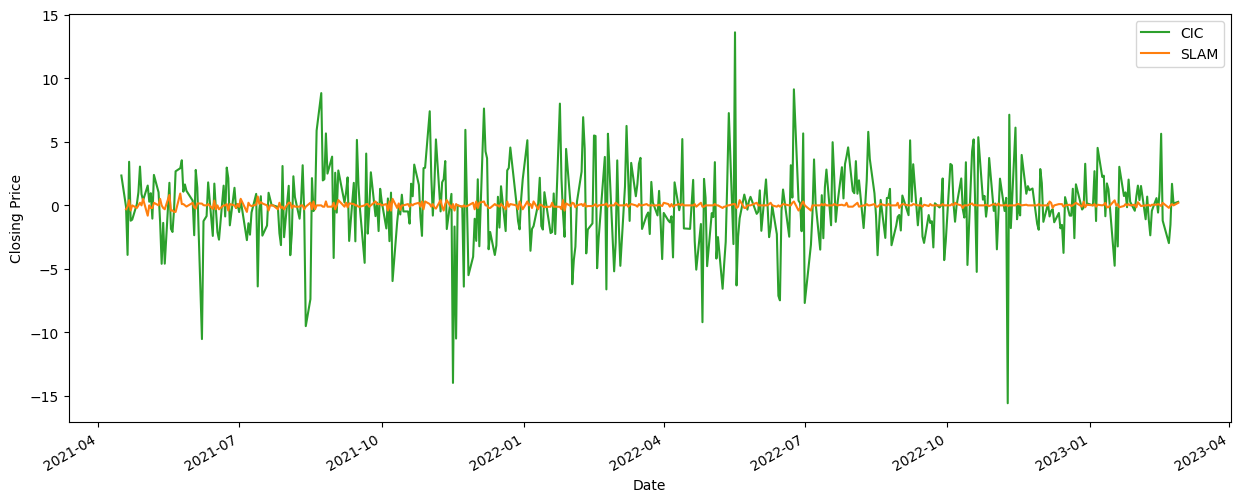

In [9]:
#Create the volatility time series plot for Sanlam and CIC
fig, ax = plt.subplots(figsize=(15, 6))
# Plot `df_suzlon` and `df_ambuja`
y_cic.plot(ax=ax, label= "CIC", color="C2")
y_sanlam.plot(ax=ax, label= "SLAM", color="C1")

# Label axes
plt.xlabel("Date")
plt.ylabel("Closing Price")



# Add legend
plt.legend();

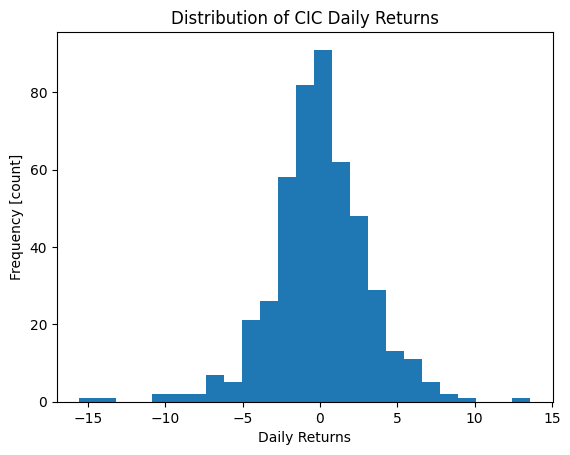

In [10]:
# Create histogram of `y_cic`, 25 bins

plt.hist(y_cic, bins=25)
# Add axis labels
plt.xlabel("Daily Returns")
plt.ylabel("Frequency [count]")


# Add title
plt.title("Distribution of CIC Daily Returns");

In [11]:
#Calculate daily volatility for CIC and Sanlam
cic_daily_volatility = y_cic.std()
sanlam_daily_volatility = y_sanlam.std()

print("CIC Daily Volatility:", cic_daily_volatility)
print("Sanlam Daily Volatility:", sanlam_daily_volatility)

CIC Daily Volatility: 3.1216766136781384
Sanlam Daily Volatility: 0.18154330691539441


In [12]:
#Calculate annual Volatility for CIC and Sanlam
cic_annual_volatility = cic_daily_volatility * np.sqrt(252)
sanlam_annual_volatility = sanlam_daily_volatility * np.sqrt(252)

print("CIC Annual Volatility:", cic_annual_volatility)
print("Sanlam Annual Volatility:", sanlam_annual_volatility)

CIC Annual Volatility: 49.55507996015164
Sanlam Annual Volatility: 2.8819106537184367


In [13]:
#Calculate the rolling volatility for cCIC , using a 50-day window
cic_rolling_50d_volatility = y_cic.rolling(window=50).std().dropna()

print("rolling_50d_volatility type:", type(cic_rolling_50d_volatility))
print("rolling_50d_volatility shape:", cic_rolling_50d_volatility.shape)
cic_rolling_50d_volatility.head()

rolling_50d_volatility type: <class 'pandas.core.series.Series'>
rolling_50d_volatility shape: (421,)


date
2021-06-25    2.556276
2021-06-28    2.541388
2021-06-29    2.541464
2021-06-30    2.480798
2021-07-01    2.432095
Name: return, dtype: float64

Focusing on CIC to create and train our model


In [14]:
#CIC
y_cic = wrangle_data(ticker="CIC", n_observations=1300)

# Is `y_cic` a Series?
assert isinstance(y_cic, pd.Series)

# Are there 470 observations in the Series?
assert len(y_cic) == 1300

# Is `y_cic` name "return"?
assert y_cic.name == "return"

# Does `y_cic` have a DatetimeIndex?
assert isinstance(y_cic.index, pd.DatetimeIndex)

# Is index sorted ascending?
assert all(y_cic.index == y_cic.sort_index(ascending=True).index)

# Are there no `NaN` values?
assert y_cic.isnull().sum() == 0

y_cic.head()

date
2017-12-21    0.000000
2017-12-22    0.000000
2017-12-26    0.310881
2017-12-27    0.000000
2017-12-28    0.000000
Name: return, dtype: float64

In [15]:
#Calculate daily volatility for CIC 
cic_daily_volatility = y_cic.std()

print("CIC Daily Volatility:", cic_daily_volatility)

CIC Daily Volatility: 3.663622096213949


In [16]:
#Calculate annual Volatility for CIC  
cic_annual_volatility = cic_daily_volatility * np.sqrt(252)

print("CIC Annual Volatility:", cic_annual_volatility)

CIC Annual Volatility: 58.15819778581956


In [17]:
#Calculate the rolling volatility for cCIC , using a 50-day window
cic_rolling_50d_volatility = y_cic.rolling(window=50).std().dropna()

print("rolling_50d_volatility type:", type(cic_rolling_50d_volatility))
print("rolling_50d_volatility shape:", cic_rolling_50d_volatility.shape)
cic_rolling_50d_volatility.head()

rolling_50d_volatility type: <class 'pandas.core.series.Series'>
rolling_50d_volatility shape: (1251,)


date
2018-03-06    0.203666
2018-03-07    0.203666
2018-03-08    0.203666
2018-03-09    0.199361
2018-03-12    0.199361
Name: return, dtype: float64

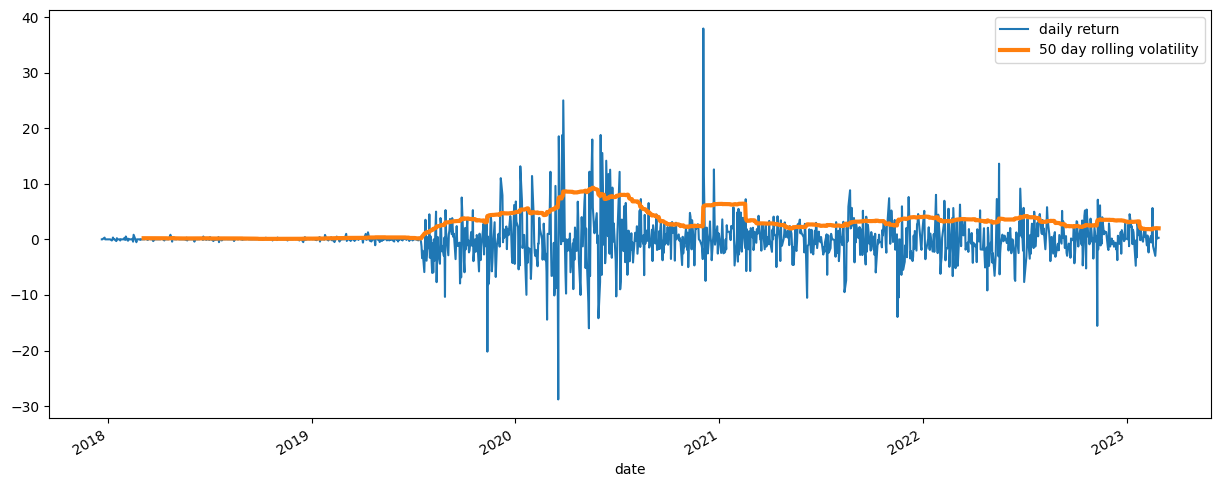

In [18]:
#Create a time series plot showing the daily returns for CIC and the 50-day rolling volatility.
fig, ax = plt.subplots(figsize=(15, 6))

# Plot `y_ambuja`
y_cic.plot(ax=ax, label="daily return")

# Plot `ambuja_rolling_50d_volatility`

cic_rolling_50d_volatility.plot(ax=ax, label="50 day rolling volatility", linewidth=3)
# Add x-axis label

plt.xlabel("date")
# Add legend
plt.legend();

Here we can see that volatility goes up when the returns change drastically — either up or down. For instance, we can see a big increase in volatility in 2020, when there were several days of large negative returns. We can also see volatility go down in 2018 to mid 2019, when there are only small day-to-day changes in returns.

This plot reveals a problem. We want to use returns to see if high volatility on one day is associated with high volatility on the following day. But high volatility is caused by large changes in returns, which can be either positive or negative. Therefore we will use the absolute value of the numbers, which is what we do to calculate performance metrics like mean absolute error. The other solution, which is more common in this context, is to square all the values.

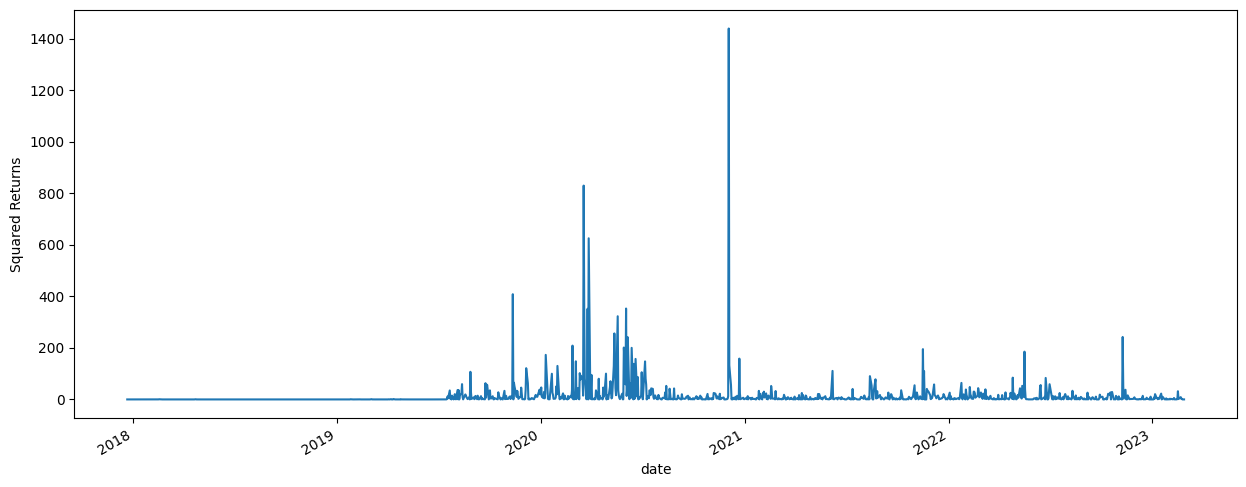

In [19]:
#Create a time series plot of the squared returns in y_cic
fig, ax = plt.subplots(figsize=(15, 6))

# Plot squared returns
(y_cic**2).plot(ax=ax)

# Add axis labels
plt.xlabel("date")
plt.ylabel("Squared Returns");

We have periods of high and low volatility, and high volatility days tend to cluster together. This is a perfect situation to use a GARCH model.

For the garch model,the p parameter handles correlations at prior time steps and a q parameter deals with "shock" events. It also uses the notion of lag. To see how many lags we should have in our model, we should create an ACF and PACF plot — but using the squared returns.

Text(0, 0.5, 'Correlation Coefficient')

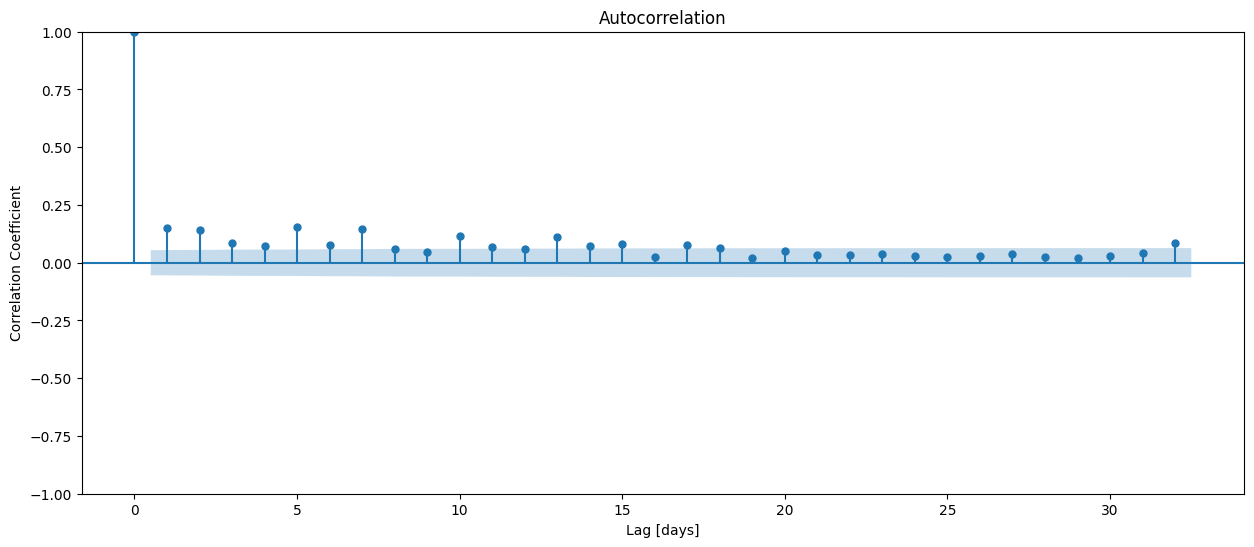

In [20]:
#Create an ACF plot of squared returns for CIC 
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared returns
plot_acf(y_cic**2,ax=ax)

# Add axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient")

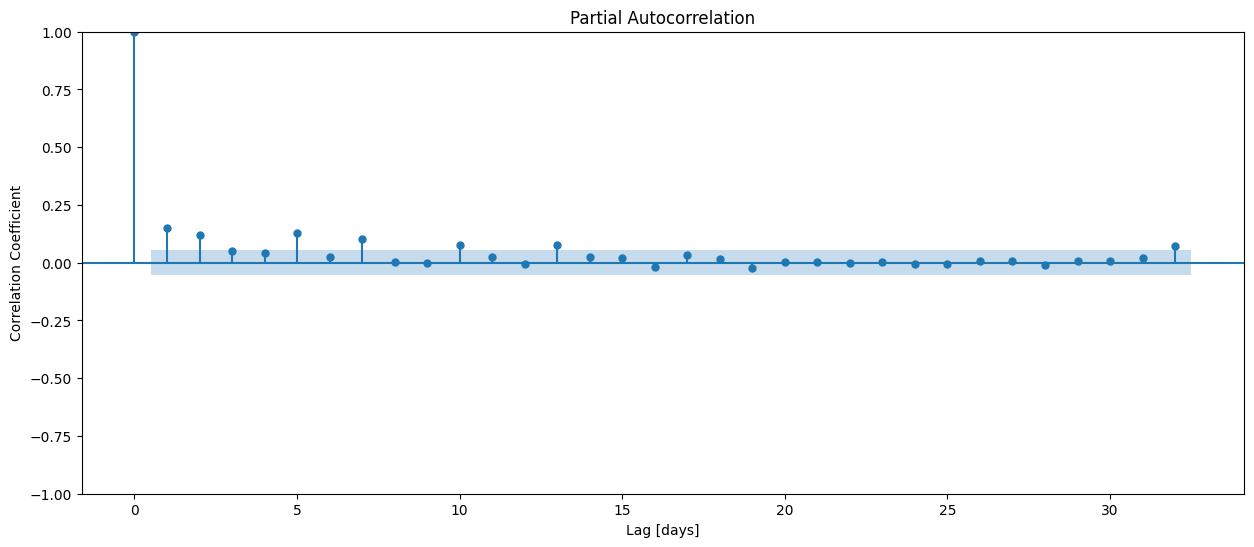

In [38]:
#Create a PACF plot of squared returns for CIC
fig, ax = plt.subplots(figsize=(15, 6))

# Create PACF of squared returns
plot_pacf(y_cic**2,ax=ax)


# Add axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient");

In our PACF, it looks like a lag of 3 would be a good starting point. 
We will not split our data into training and test sets, and then set a baseline because our model's input and its output are two different measurements. We'll use returns to train our model, but we want it to predict volatility

3.4 Split
create a training set and conduct walk-forward validation after we've built our model

In [22]:
#Create a training set y_cic_train that contains the first 80% of the observations in y_cic.
cutoff_test = int(len(y_cic) * 0.8)
y_cic_train = y_cic.iloc[:cutoff_test]

print("y_cic_train type:", type(y_cic_train))
print("y_cic_train shape:", y_cic_train.shape)
y_cic_train.tail()

y_cic_train type: <class 'pandas.core.series.Series'>
y_cic_train shape: (1040,)


date
2022-02-07    2.653631
2022-02-08    6.938776
2022-02-09    4.452926
2022-02-10   -3.775883
2022-02-11   -1.898734
Name: return, dtype: float64

3.5 Build Model

Iterating our model

Build and fit a GARCH model using the data in y_cic. Start with 3 as the value for p and q

In [23]:
# Build and train model
model = arch_model(
    y_cic_train,
    p=1,
    q=1,
    rescale=False
).fit(disp=0)
print("model type:", type(model))

# Show model summary
model.summary

model type: <class 'arch.univariate.base.ARCHModelResult'>


<bound method ARCHModelResult.summary of                      Constant Mean - GARCH Model Results                      
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1920.20
Distribution:                  Normal   AIC:                           3848.40
Method:            Maximum Likelihood   BIC:                           3868.18
                                        No. Observations:                 1040
Date:                Wed, Mar 01 2023   Df Residuals:                     1039
Time:                        10:55:16   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.

In [24]:
#Create a time series plot with the CIC returns and the conditional volatility for the model
model.conditional_volatility.tail()

date
2022-02-07    3.400334
2022-02-08    3.317152
2022-02-09    3.931083
2022-02-10    3.994902
2022-02-11    3.971893
Name: cond_vol, dtype: float64

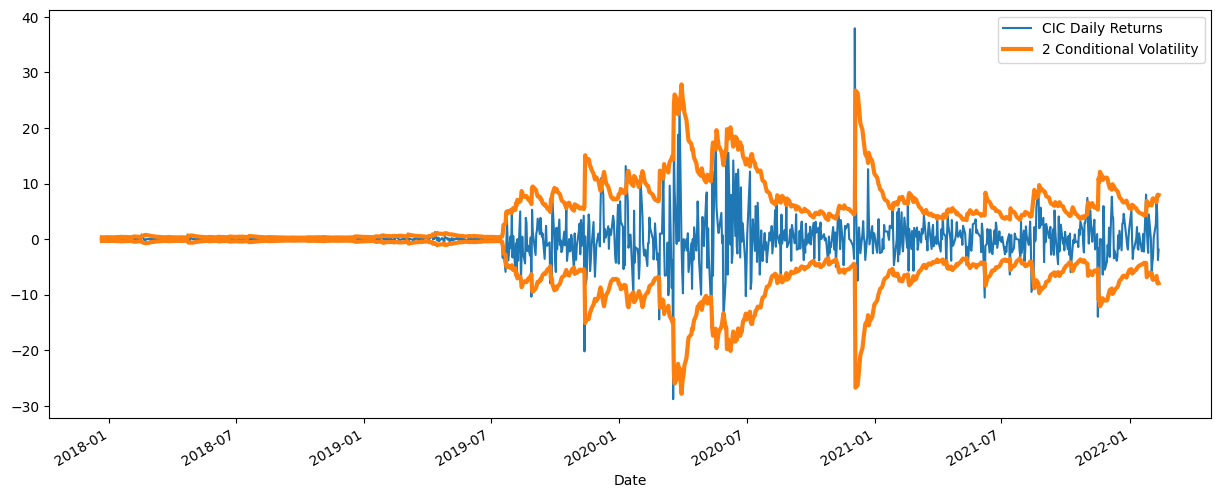

In [25]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot `y_ambuja_train`

y_cic_train.plot(ax=ax, label="CIC Daily Returns")
# Plot conditional volatility * 2
(2 * model.conditional_volatility).plot(
    ax=ax, color="C1", label="2 Conditional Volatility", linewidth=3
)

# Plot conditional volatility * -2
(-2 * model.conditional_volatility.rename("")).plot(
    ax=ax, color="C1", linewidth=3
)

# Add axis labels
plt.xlabel("Date")


# Add legend
plt.legend();

Our model looks pretty good, but we should examine residuals to make sure

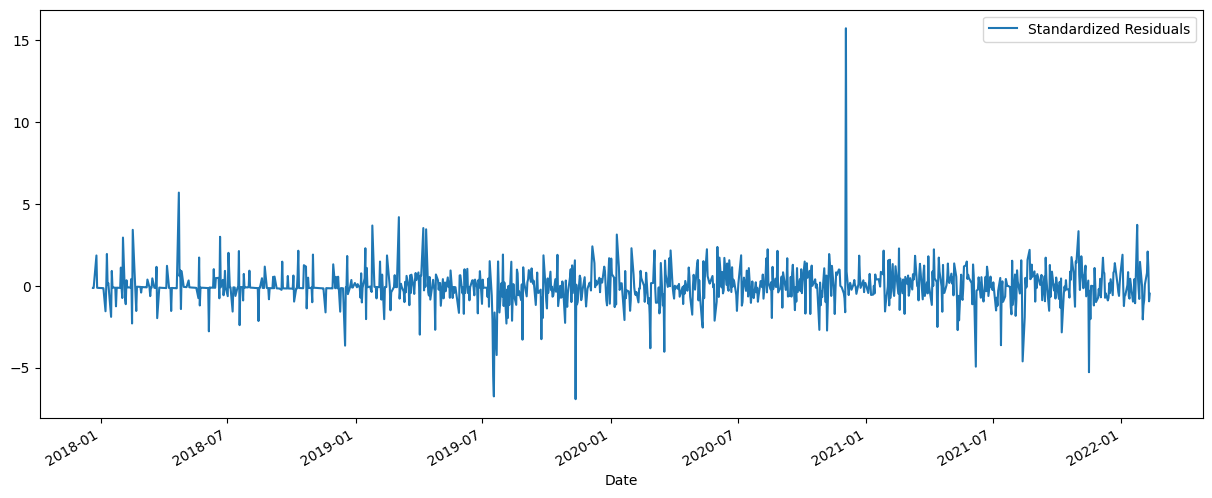

In [26]:
#Create a time series plot of the standardized residuals for your model
fig, ax = plt.subplots(figsize=(15, 6))

# Plot standardized residuals
model.std_resid.plot(ax=ax, label="Standardized Residuals")

# Add axis labels

plt.xlabel("Date")

# Add legend
plt.legend();

These residuals look good: they have a consistent mean and spread over time. Let's check their normality using a histogram

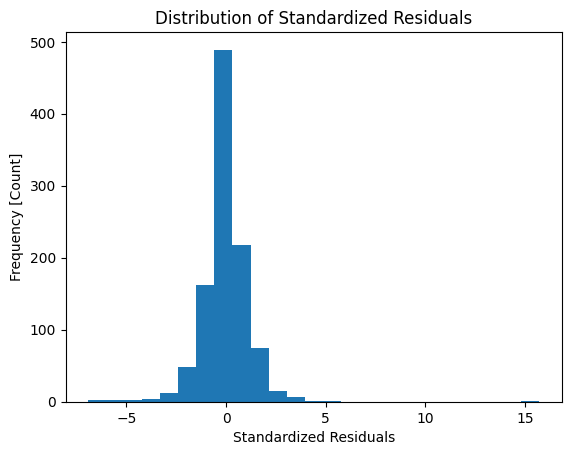

In [27]:
#Create a histogram with 25 bins of the standardized residuals for your model.
plt.hist(model.std_resid, bins=25)

# Add axis labels

plt.xlabel("Standardized Residuals")
plt.ylabel("Frequency [Count]")
# Add title
plt.title("Distribution of Standardized Residuals");

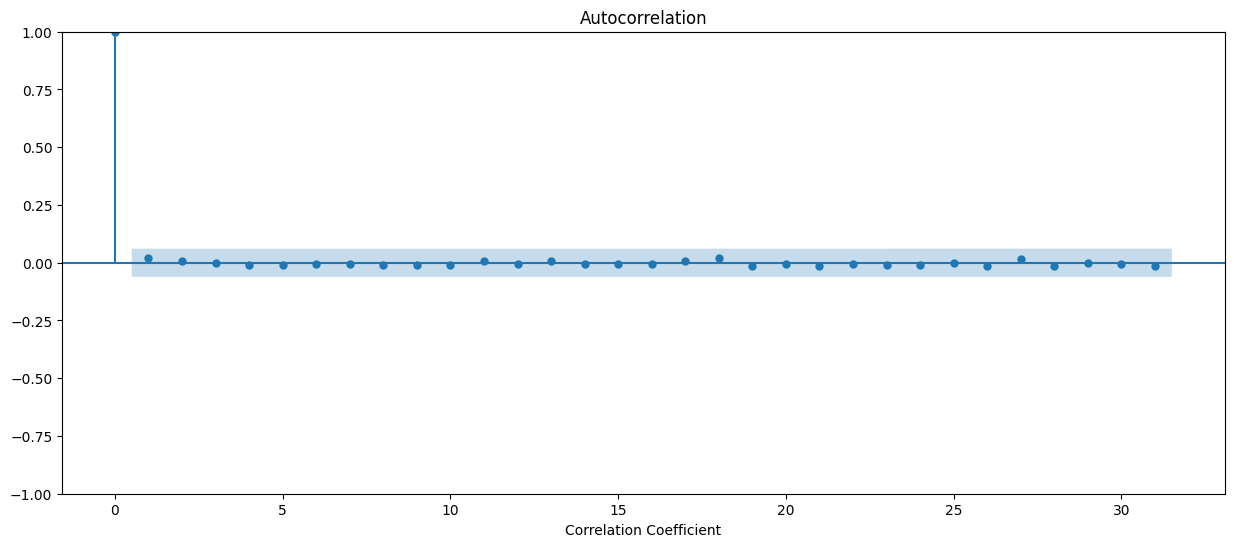

In [28]:
#Create an ACF plot of the square of your standardized residuals.
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared, standardized residuals
plot_acf(model.std_resid**2, ax=ax)

# Add axis labels
plt.xlabel("Lag [Days]")
plt.xlabel("Correlation Coefficient");

We just have a hundred percent correlation at the first time step because the number is correlated with itself but the rest is within the blue band hence not significant

In [29]:
#Create a one-day forecast from your model and assign the result to the variable one_day_forecast.
one_day_forecast = model.forecast(horizon=1, reindex=False).variance

print("one_day_forecast type:", type(one_day_forecast))
one_day_forecast

one_day_forecast type: <class 'pandas.core.frame.DataFrame'>


,h.1
date,
2022-02-11,14.318002


our model forecast shows the predicted variance,we square the value to get standard deviation / volatility.

In [30]:
one_day_forecast.iloc[0,0]**0.5

3.783913569366191

Walk-forward validation on the model

In [ ]:
# Create empty list to hold predictions
predictions = []

# Calculate size of test data (20%)
test_size = int(len(y_cic) * 0.2)

# Walk forward
for i in range(test_size):
    # Create test data
    y_train = y_cic.iloc[: -(test_size - i)]

    # Train model
    model = arch_model(y_train,p=1, q=1, rescale=False).fit(disp=0)

    # Generate next prediction (volatility, not variance)
    next_pred = model.forecast(horizon=1, reindex=False).variance.iloc[0,0] **0.5

    # Append prediction to list
    predictions.append(next_pred)

# Create Series from predictions list
y_test_wfv = pd.Series(predictions, index=y_cic.tail(test_size).index)

print("y_test_wfv type:", type(y_test_wfv))
print("y_test_wfv shape:", y_test_wfv.shape)
y_test_wfv.head()

/usr/local/python/3.10.4/lib/python3.10/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/python/3.10.4/lib/python3.10/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/python/3.10.4/lib/python3.10/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/python/3.10.4/lib/python3.10/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.opti

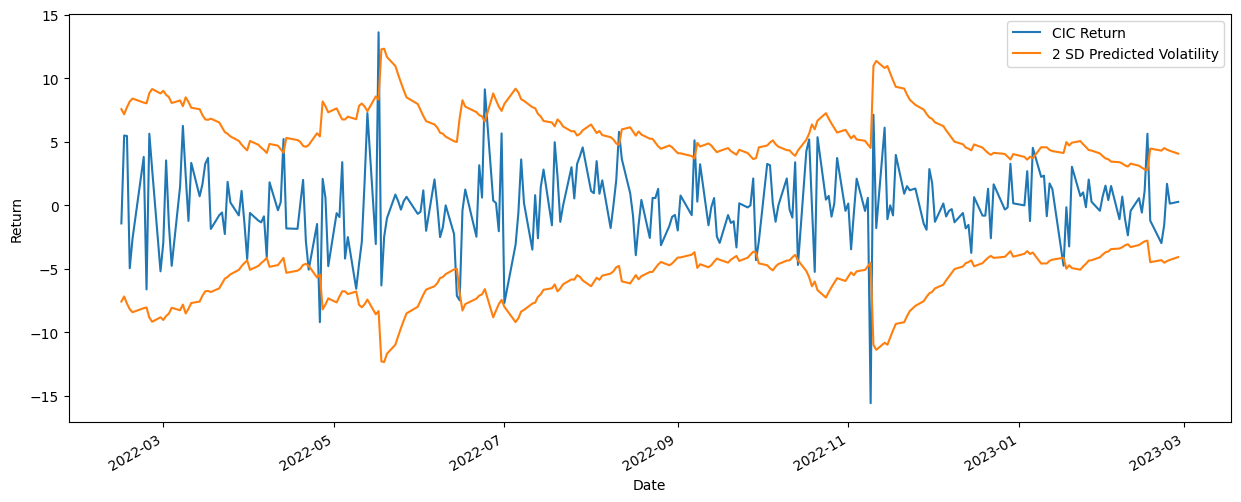

In [32]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot returns for test data
y_cic.tail(test_size).plot(ax=ax, label="CIC Return")

# Plot volatility predictions * 2
(2 * y_test_wfv).plot(ax=ax, c="C1", label="2 SD Predicted Volatility")

# Plot volatility predictions * -2
(-2 * y_test_wfv).plot(ax=ax, c="C1")

# Label axes
plt.xlabel("Date")
plt.ylabel("Return")

# Add legend
plt.legend();

This looks pretty good. Our volatility predictions seem to follow the changes in returns over time.

One additional step we could do to evaluate how our model performs on the test data would be to plot the ACF of the standardized residuals for only the test set.

We start with a prediction, which contains a 5-day forecast from our model

In [33]:
# Generate 5-day volatility forecast
prediction = model.forecast(horizon=5, reindex=False).variance ** 0.5
print(prediction)

# Calculate forecast start date
start = prediction.index[0] + pd.DateOffset(days=1)

# Create date range
prediction_dates = pd.bdate_range(start=start, periods=prediction.shape[1])

# Create prediction index labels, ISO 8601 format
prediction_index = [d.isoformat() for d in prediction_dates]

print("prediction_index type:", type(prediction_index))
print("prediction_index len:", len(prediction_index))
prediction_index[:3]

                 h.1       h.2       h.3       h.4       h.5
date                                                        
2023-02-24  2.034228  2.034561  2.034894  2.035226  2.035559
prediction_index type: <class 'list'>
prediction_index len: 5


['2023-02-27T00:00:00', '2023-02-28T00:00:00', '2023-03-01T00:00:00']

create a function to combine the index and predictions, and then return a dictionary where each key is a date and each value is a predicted volatility

Create a clean_prediction function that takes a variance prediction DataFrame as input and return a dictionary where each key is a date in ISO 8601 format and each value is the predicted volatility. Assert statements to test your function.

In [34]:
def clean_prediction(prediction):

    """Reformat model prediction to JSON.

    Parameters
    ----------
    prediction : pd.DataFrame
        Variance from a `ARCHModelForecast`

    Returns
    -------
    dict
        Forecast of volatility. Each key is date in ISO 8601 format.
        Each value is predicted volatility.
    """
    # Calculate forecast start date
    start = prediction.index[0] + pd.DateOffset(days=1)

    # Create date range
    prediction_dates = pd.bdate_range(start=start, periods=prediction.shape[1])

    # Create prediction index labels, ISO 8601 format
    prediction_index = [d.isoformat() for d in prediction_dates]

    # Extract predictions from DataFrame, get square root
    data=prediction.values.flatten() ** 0.5

    # Combine `data` and `prediction_index` into Series
    prediction_formatted=pd.Series(data, index=prediction_index)

    # Return Series as dictionary
    return prediction_formatted.to_dict()

In [35]:
prediction = model.forecast(horizon=10, reindex=False).variance
prediction_formatted = clean_prediction(prediction)

# Is `prediction_formatted` a dictionary?
assert isinstance(prediction_formatted, dict)

# Are keys correct data type?
assert all(isinstance(k, str) for k in prediction_formatted.keys())

# Are values correct data type
assert all(isinstance(v, float) for v in prediction_formatted.values())

prediction_formatted

{'2023-02-27T00:00:00': 2.034228168399256,
 '2023-02-28T00:00:00': 2.034560937933005,
 '2023-03-01T00:00:00': 2.034893657591185,
 '2023-03-02T00:00:00': 2.035226327398319,
 '2023-03-03T00:00:00': 2.0355589473789104,
 '2023-03-06T00:00:00': 2.035891517557443,
 '2023-03-07T00:00:00': 2.0362240379583807,
 '2023-03-08T00:00:00': 2.0365565086061683,
 '2023-03-09T00:00:00': 2.03688892952523,
 '2023-03-10T00:00:00': 2.037221300739971}

We now have several components for our application: classes for getting data from an API, classes for storing it in a database, and code for building our model and cleaning our predictions. The next step is creating a class for our model and paths for application